-- Importing libraries and setting global plot design --

In [81]:
import os
import math
import numpy as np
import pandas as pd
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

-- Loading Data --

In [82]:
cars_data = os.path.join("..", "car_adverts.csv") #go up a directory to find car_adverts.csv

cars = pd.read_csv(cars_data)
cars.head()

,Unnamed: 0,make,model,variant,car_price,car_badges,car_title,car_sub_title,car_attention_grabber,car_specs,...,num_owner,ulez,full_service,part_service,part_warranty,full_dealership,first_year_road_tax,brand_new,finance_available,discounted
0,0,AC,Cobra,NaN,89995.0,NaN,AC Cobra,4.9 MK IV CRS 2dr,GENUINE AC COBRA CRS 522 BHP,"2001 (X reg), Convertible, 14,400 miles, 4.9L,...",...,5.0,0,0,0,0,0,0,0,0,0
1,1,AC,Cobra,NaN,92500.0,'',AC Cobra,378 - MkIV,PHYSICAL CAR!,"2019 (T reg), Convertible, 650 miles, Manual, ...",...,NaN,0,0,0,0,0,0,0,0,0
2,2,AC,Cobra,NaN,109995.0,'',AC Cobra,MK1V 212 SC. 3.5 V8 350 BHP LOTUS TWIN TURBO. ...,FULL CARBON FIBRE BODY.,"2000 (X reg), Convertible, 21,600 miles, 3.5L,...",...,3.0,0,0,0,0,0,0,0,0,0
3,3,AC,Cobra,NaN,124950.0,'',AC Cobra,302 MKIV 2dr,ABSOLUTELY STUNNING,"1989 (F reg), Convertible, 2,750 miles, Manual...",...,NaN,0,0,0,0,0,0,0,0,0
4,4,AC,Cobra,NaN,124950.0,'',AC Cobra,302 MKIV With Factory Lightweight Engine 5.0 2dr,'STAGE 3' SVO ENGINE,"1989 (E reg), Convertible, 15,142 miles, 5.0L,...",...,NaN,0,0,0,0,0,0,0,0,0


-- Initial Dataset Exploration --

In [83]:
cars.shape

(818456, 32)

In [84]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818456 entries, 0 to 818455
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             818456 non-null  int64  
 1   make                   818456 non-null  object 
 2   model                  818153 non-null  object 
 3   variant                816207 non-null  object 
 4   car_price              818456 non-null  float64
 5   car_badges             801459 non-null  object 
 6   car_title              818456 non-null  object 
 7   car_sub_title          817909 non-null  object 
 8   car_attention_grabber  738163 non-null  object 
 9   car_specs              818456 non-null  object 
 10  car_seller             818348 non-null  object 
 11  car_seller_rating      644191 non-null  float64
 12  car_seller_location    816256 non-null  object 
 13  year                   818456 non-null  object 
 14  reg                    747436 non-nu

In [85]:
cars.columns

Index(['Unnamed: 0', 'make', 'model', 'variant', 'car_price', 'car_badges',
       'car_title', 'car_sub_title', 'car_attention_grabber', 'car_specs',
       'car_seller', 'car_seller_rating', 'car_seller_location', 'year', 'reg',
       'body_type', 'miles', 'engine_vol', 'engine_size', 'engine_size_unit',
       'transmission', 'feul_type', 'num_owner', 'ulez', 'full_service',
       'part_service', 'part_warranty', 'full_dealership',
       'first_year_road_tax', 'brand_new', 'finance_available', 'discounted'],
      dtype='object')

-- Dropping unnecessary columns, feature engineering and filling missing values --

In [86]:
drop_cols = [
    "Unnamed: 0",
    "car_title",
    "car_sub_title",
    "car_attention_grabber",
    "car_badges",
    "car_specs",
    "car_seller",
    "car_seller_location",
    "car_seller_rating",
    "engine_size_unit",
    "first_year_road_tax",
    "finance_available",
    "discounted",
    "variant",
    "full_dealership",
    "engine_size_unit",
    "num_owner",
    "ulez",
    "full_service",
    "part_service",
    "part_warranty",
    "brand_new"
]

cars = cars.drop(columns=drop_cols) #dropping unnecessary columns

In [87]:
cars.isnull().sum() #checking for missing values after dropping columns

make                0
model             303
car_price           0
year                0
reg             71020
body_type         712
miles           54753
engine_vol      15446
engine_size      4209
transmission      213
feul_type         222
dtype: int64

In [88]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818456 entries, 0 to 818455
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   make          818456 non-null  object 
 1   model         818153 non-null  object 
 2   car_price     818456 non-null  float64
 3   year          818456 non-null  object 
 4   reg           747436 non-null  object 
 5   body_type     817744 non-null  object 
 6   miles         763703 non-null  float64
 7   engine_vol    803010 non-null  float64
 8   engine_size   814247 non-null  float64
 9   transmission  818243 non-null  object 
 10  feul_type     818234 non-null  object 
dtypes: float64(4), object(7)
memory usage: 68.7+ MB


In [89]:
cars = cars.rename(columns={"feul_type": "fuel_type"})

In [90]:
cars["reg"] = cars["reg"].str.extract(r'(\d+)')
cars["reg"] = pd.to_numeric(cars["reg"], errors="coerce")

In [91]:
def clean_year(value):
    try:
        return float(value)   #succeeds for ints/floats
    except:
        return np.nan         #anything else is filled with NaN

cars["year"] = cars["year"].apply(clean_year)

In [92]:
numeric_cols = [
    "miles", "engine_vol", "engine_size"
]

for column in numeric_cols:
    cars[column] = cars[column].fillna(cars[column].median())

In [93]:
categorical_cols = [
    "model", "make", "body_type", "transmission", "fuel_type"
]

for column in categorical_cols:
    cars[column] = cars[column].fillna(np.nan)

In [94]:
#cars["reg"] = cars["reg"].astype("int64")

In [95]:
def compute_age(row):

    current_year = datetime.now().year
    
    if pd.notna(row["year"]):
        return  current_year - row["year"]

    if pd.notna(row["reg"]):
        return current_year - (2000 + row["reg"] % 50)
    
    return np.nan

#cars["age"] = current_year - (2000 + (cars["reg"] % 50))
cars["age"] = cars.apply(compute_age, axis=1)


In [96]:
numeric_cols_final = [
    "miles", "engine_vol", "engine_size", "age"
]

In [97]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818456 entries, 0 to 818455
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   make          818456 non-null  object 
 1   model         818153 non-null  object 
 2   car_price     818456 non-null  float64
 3   year          770376 non-null  float64
 4   reg           743702 non-null  float64
 5   body_type     817744 non-null  object 
 6   miles         818456 non-null  float64
 7   engine_vol    818456 non-null  float64
 8   engine_size   818456 non-null  float64
 9   transmission  818243 non-null  object 
 10  fuel_type     818234 non-null  object 
 11  age           770376 non-null  float64
dtypes: float64(7), object(5)
memory usage: 74.9+ MB


In [98]:
cars.isnull().sum()

make                0
model             303
car_price           0
year            48080
reg             74754
body_type         712
miles               0
engine_vol          0
engine_size         0
transmission      213
fuel_type         222
age             48080
dtype: int64

In [99]:
cars.head(30)

,make,model,car_price,year,reg,body_type,miles,engine_vol,engine_size,transmission,fuel_type,age
0,AC,Cobra,89995.0,2001.0,NaN,convertible,14400.0,4.9,225.0,manual,petrol,25.0
1,AC,Cobra,92500.0,2019.0,NaN,convertible,650.0,1.6,148.0,manual,petrol,7.0
2,AC,Cobra,109995.0,2000.0,NaN,convertible,21600.0,3.5,148.0,manual,petrol,26.0
3,AC,Cobra,124950.0,1989.0,NaN,convertible,2750.0,1.6,148.0,manual,petrol,37.0
4,AC,Cobra,124950.0,1989.0,NaN,convertible,15142.0,5.0,148.0,manual,petrol,37.0
5,AC,Cobra,145500.0,2022.0,22.0,convertible,500.0,1.6,148.0,manual,petrol,4.0
6,AC,NaN,124950.0,1989.0,NaN,convertible,2750.0,1.6,148.0,manual,petrol,37.0
7,AC,NaN,89995.0,2001.0,NaN,convertible,14400.0,4.9,225.0,manual,petrol,25.0
8,Abarth,124 Spider,24275.0,2019.0,19.0,convertible,10313.0,1.4,167.0,automatic,petrol,7.0
9,Abarth,124 Spider,24275.0,2019.0,19.0,convertible,10313.0,1.4,167.0,automatic,petrol,7.0


In [100]:
missing_age_rows = cars[cars["year"].isna() & cars["reg"].isna()]
len(missing_age_rows)

48080

-- In-Depth EDA --

In [101]:
def show_outlier_ranges(df, col):
    print(col)
    print(cars[col].describe(percentiles=[0.005, 0.01, 0.99, 0.995]))
    print("\n")

for col in numeric_cols:
    show_outlier_ranges(cars, col)


miles
count    818456.000000
mean      48169.305630
std       35340.834227
min           2.000000
0.5%        100.000000
1%         1000.000000
50%       40267.000000
99%      151000.000000
99.5%    166256.000000
max      999999.000000
Name: miles, dtype: float64


engine_vol
count    818456.000000
mean          1.855372
std           0.746467
min           0.500000
0.5%          0.900000
1%            0.900000
50%           1.600000
99%           5.000000
99.5%         5.200000
max           8.300000
Name: engine_vol, dtype: float64


engine_size
count    818456.000000
mean        170.020296
std          91.917849
min           1.000000
0.5%         64.000000
1%           67.000000
50%         148.000000
99%         560.000000
99.5%       605.000000
max        2460.000000
Name: engine_size, dtype: float64




In [102]:
def remove_outliers(df, col, lower_q, upper_q):
    low = cars[col].quantile(lower_q)
    high = cars[col].quantile(upper_q)
    return cars[(cars[col] >= low) & (cars[col] <= high)]

outlier_cols = [
    "miles",
    "engine_size",
    "engine_vol",
    "age",
    "year",
    "reg"
]

for col in outlier_cols:
    cars = remove_outliers(cars, col, 0.005, 0.995)

#PLAY WITH THIS, SEE WHAT GIVES BEST RESULTS AND WHAT IS MOST REALISTIC IRL, ADD A FOR LOOP TO AUTOMATE CALLING THE FUNCTION

In [103]:
for col in categorical_cols:
    cars[col] = cars[col].str.lower().str.strip().str.replace(" ", "_", regex=False)


In [104]:
cars_cleaned = cars.copy()
cars_cleaned.to_csv("cars_cleaned.csv", index=False)

In [105]:
cars["log_price"] = np.log1p(cars["car_price"])

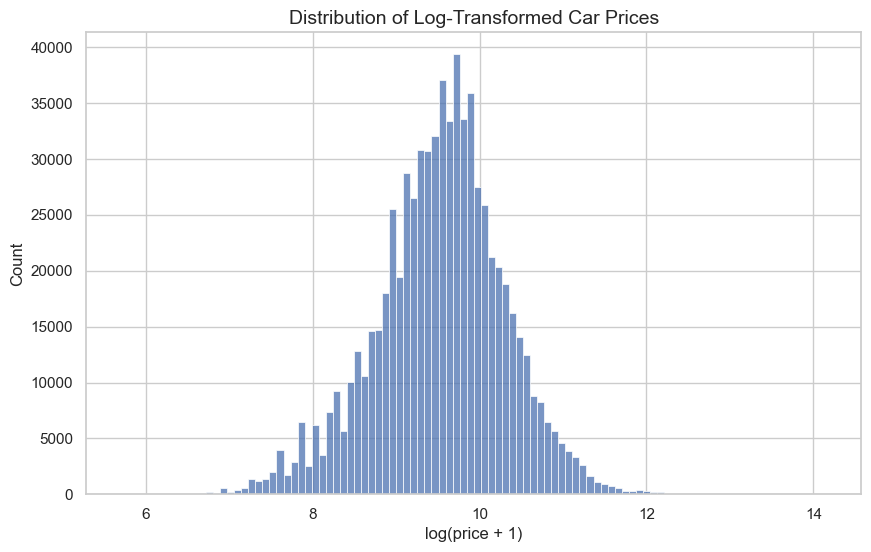

In [106]:
sns.histplot(cars["log_price"], bins=100)
plt.title("Distribution of Log-Transformed Car Prices")
plt.xlabel("log(price + 1)")
plt.show()

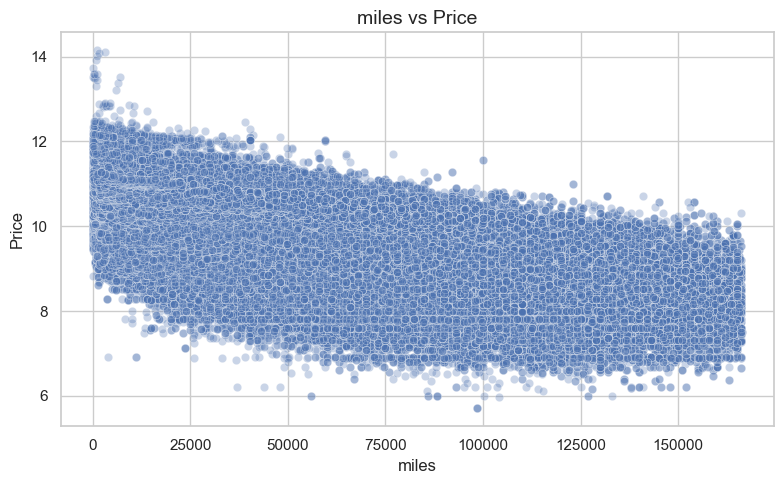

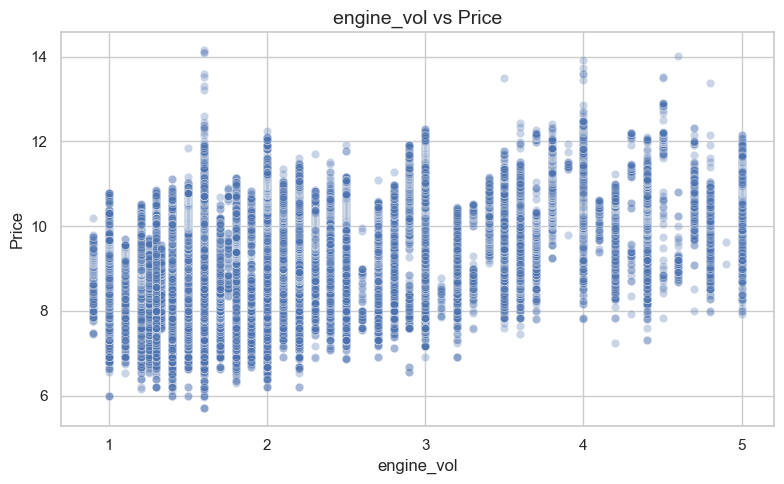

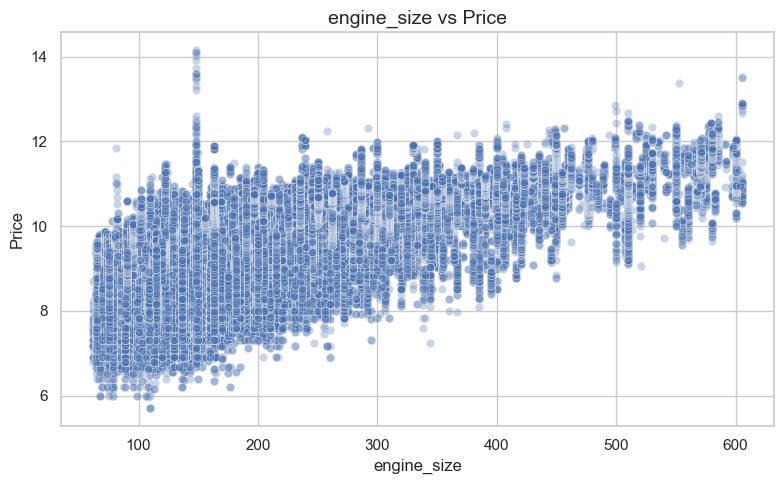

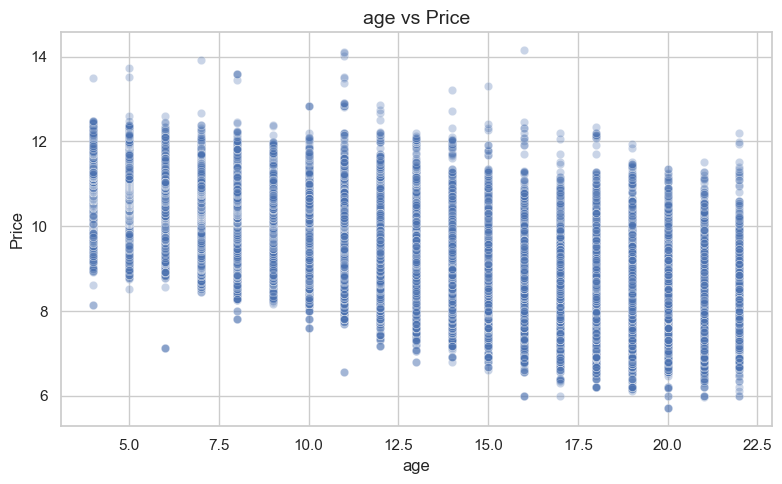

In [107]:
def scatter_price(df, target="log_price"):
    scatter_cols = ["miles", "engine_vol", "engine_size", "age"]

    for col in scatter_cols:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=df, x=col, y=target, alpha=0.3)
        plt.title(f"{col} vs Price")
        plt.xlabel(col)
        plt.ylabel("Price")
        plt.tight_layout()
        plt.show()

scatter_price(cars)

-- Top 5 most common entries in categorical columns --

In [108]:
'''
---------------------- FINISH THIS FUNCTION LATER ----------------------
def cat_dist_vis(df):
    
    for col in categorical_cols:
        plt.figure(figsize=(8, 5))
        sns.histplot(cars[col], bins=1000)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.show()

cat_dist_vis(cars)
'''

unique_makes = sorted(cars["make"].dropna().str.lower().unique())
unique_models = sorted(cars["model"].dropna().str.lower().unique())

print("Makes:")
for m in unique_makes:
    print(f'"{m}",')

print("\nModels:")
for m in unique_models:
    print(f'"{m}",')

Makes:
"abarth",
"ac",
"ak",
"alfa_romeo",
"alpine",
"ariel",
"aston_martin",
"audi",
"bac",
"bentley",
"bmw",
"bowler",
"cadillac",
"caterham",
"chevrolet",
"chrysler",
"citroen",
"crendon",
"cupra",
"dacia",
"daewoo",
"daihatsu",
"daimler",
"dax",
"dfsk",
"dodge",
"ds_automobiles",
"ferrari",
"fiat",
"ford",
"gardener",
"gbs",
"genesis_motor",
"gmc",
"great_wall",
"honda",
"hummer",
"hyundai",
"infiniti",
"isuzu",
"iveco",
"jaguar",
"jba",
"jeep",
"kia",
"ktm",
"lada",
"lamborghini",
"land_rover",
"levc",
"lexus",
"lincoln",
"london_taxis_international",
"lotus",
"maserati",
"mazda",
"mclaren",
"mercedes-benz",
"mev",
"mg",
"mini",
"mitsubishi",
"moke",
"morgan",
"ng",
"nissan",
"oldsmobile",
"perodua",
"peugeot",
"piaggio",
"polaris",
"polestar",
"porsche",
"proton",
"radical",
"renault",
"robin_hood",
"rover",
"royale",
"saab",
"seat",
"skoda",
"smart",
"ssangyong",
"subaru",
"suzuki",
"tesla",
"tiger",
"toyota",
"tvr",
"ultima",
"vauxhall",
"volkswagen",
"volvo",
"westfield",
"yam

-- Train-Test Split --

In [109]:
X = cars.drop(columns=["car_price"])
y = cars["log_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
numeric_transformer = SimpleImputer(strategy="median")

In [111]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [112]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols_final),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [113]:
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgb", XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    ))
])

In [114]:
lr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lr", LinearRegression())
])

In [115]:
lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['miles', 'engine_vol',
                                                   'engine_size', 'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['model', 'make', 'body_type',
                                                   'transmission',
                                                   'fuel_type'])])),
                ('lr', LinearRegression())])

In [116]:
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['miles', 'engine_vol',
                                                   'engine_size', 'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['model', 'make', 'body_type',
                                                   'transmission',
                                                   'fuel_type'])])),
                ('xgb',
                 XGBRegre...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=400, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [117]:
lr_preds = lr_model.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_mape = mean_absolute_percentage_error(y_test, lr_preds)
lr_rmse = mean_squared_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)

y_test_pounds = np.expm1(y_test)
lr_preds_pounds = np.expm1(lr_preds)
lr_mape_pounds = mean_absolute_percentage_error(y_test_pounds, lr_preds_pounds)
lr_mae_pounds = mean_absolute_error(y_test_pounds, lr_preds_pounds)
lr_rmse_pounds = mean_squared_error(y_test_pounds, lr_preds_pounds, squared=False)

print(f"Linear Regression (log-prices) - MAPE: {lr_mape}, MAE: {lr_mae:,.2f}, RMSE: {lr_rmse:,.2f}, R2: {lr_r2:.4f}")
print(f"Linear Regression (£) - MAPE: {lr_mape_pounds:,.2}, MAE: {lr_mae_pounds:,.2f}, RMSE: {lr_rmse_pounds:,.2f}")

Linear Regression (log-prices) - MAPE: 0.01682283936843098, MAE: 0.16, RMSE: 0.05, R2: 0.9185
Linear Regression (£) - MAPE: 0.16, MAE: 3,001.21, RMSE: 7,608.31


In [ ]:
xgb_preds = xgb_model.predict(X_test)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_preds)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = mean_squared_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

xgb_preds_pounds = np.expm1(xgb_preds)
xgb_mape_pounds = mean_absolute_percentage_error(y_test_pounds, xgb_preds_pounds)
xgb_mae_pounds = mean_absolute_error(y_test_pounds, xgb_preds_pounds)
xgb_rmse_pounds = mean_squared_error(y_test_pounds, xgb_preds_pounds, squared=False)

print(f"XGBoost Regressor (log-prices) - MAE: {lr_mae:,.2f}, RMSE: {xgb_rmse:,.2f}, R2: {xgb_r2:.4f}")
print(f"XGBoost Regression (£) - MAPE: {xgb_mape_pounds:,.2f}, MAE: {xgb_mae_pounds:,.2f}, RMSE: {xgb_rmse_pounds:,.2f}")

XGBoost Regressor (log-prices) - MAE: 0.16, RMSE: 0.02, R2: 0.9684
XGBoost Regression (£) - MAPE: 0.10, MAE: 0.10, RMSE: 3.9e+03


In [119]:
#ADD IN ALL THE ROWS WITH "G REG" AND ADD IN A ROW WITH ENGINE SPECIFICS LIKE "MK7" AND "SDRIVE 18i"